# Init

In [1]:
%matplotlib inline

import csv
import datetime
import json
import matplotlib
import time
import logging
import sys
import sqlite3
import os
import random

import gensim

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn.manifold import TSNE
from gensim.models import Word2Vec, KeyedVectors
from scipy.sparse import coo_matrix, csr_matrix
from scipy.io import loadmat, savemat
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [2]:
from scoring import scoring
from fastrp import *

In [3]:
# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from jupyter_client import find_connection_file

In [6]:
find_connection_file()

'/run/user/2002/jupyter/kernel-82b8824a-9e0f-4a2f-a255-3664d0160698.json'

In [7]:
matplotlib.style.use('ggplot')
sns.set(color_codes=True)

# Read Data

In [8]:
ls /mnt/store1/hcchen/www-network

10k-classification.mat  edges.txt  ranks.txt  vertices.txt


In [9]:
data_dir = '/mnt/store1/hcchen/www-network/'
rank_fname = 'ranks.txt'
edges_fname = 'edges.txt'
vertices_fname = 'vertices.txt'

Get node to ID mapping:

In [11]:
%%time
node_to_id = {}
with open(os.path.join(data_dir, vertices_fname), 'r') as fp:
    reader = csv.reader(fp, delimiter='\t')
    for row in tqdm(reader, total=387806511):
        node_to_id[row[1]] = row[0]


CPU times: user 8min, sys: 1min 21s, total: 9min 21s
Wall time: 9min 5s


Filter based on harmony centrality:

In [12]:
K = 10000

In [13]:
%%time
node_set = set()

with open(os.path.join(data_dir, rank_fname)) as fp:
    reader = csv.DictReader(fp, delimiter='\t')
    for i, row in enumerate(reader):
        if i >= K:
            break
        node_set.add(node_to_id[row['#host_rev']])

CPU times: user 37.3 ms, sys: 31.7 ms, total: 69 ms
Wall time: 96.6 ms


This mapping is huge, so we are going to only take the relevant part later (i.e. for top-K nodes).

In [14]:
%time node_to_id = {node: id for node, id in node_to_id.items() if id in node_set}

CPU times: user 1min 8s, sys: 29.3 s, total: 1min 37s
Wall time: 1min 37s


In [15]:
%time id_to_node = {id: node for node, id in node_to_id.items()}

CPU times: user 5.28 ms, sys: 7.5 ms, total: 12.8 ms
Wall time: 12.7 ms


The goal is to choose the subgraph with only the top-K most important nodes:

In [16]:
with open(os.path.join(data_dir, rank_fname), 'r') as fp:
    for i, row in enumerate(fp):
        print (row, end="")
        if i >= 5:
            break

#hc_pos	#hc_val	#pr_pos	#pr_val	#host_rev
1	38039408	1	0.00775205006207982	com.facebook
2	34958084	3	0.00428814229894441	com.twitter
3	33540440	2	0.00540973218887675	com.googleapis.fonts
4	32887486	4	0.00286280981132588	com.youtube
5	31128886	7	0.00167971398905038	com.google.plus


Construct the subgraph consisting of top-K nodes: (this is slow, taking ~30min)

In [58]:
G = nx.Graph()

with open(os.path.join(data_dir, edges_fname)) as fp:
    for line in tqdm(fp, total=2504610000):
        row = line.strip().split('\t')
        if row[0] in node_set and row[1] in node_set:
            # print (id_to_node[row[0]], id_to_node[row[1]])
            G.add_edge(row[0], row[1])

KeyboardInterrupt: 

In [ ]:
nx.write_adjlist(G, open('network-10k.adjlist', 'wb'))

**Note: we need additional post-processing to remove some unnecessary content in the adj list file!!**

But it seems that even without post-processing our algorithm is working well. Weird :-)

# DeepWalk

We run the following command in terminal:

In [ ]:
deepwalk --format adjlist --input network-10k.adjlist \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 38 --output www-network/10k.embeddings

# Construct Dataset

Read the 10K graph from file:

In [341]:
G = nx.read_adjlist('/mnt/store1/hcchen/ws/large-network-embeddings/www-network/network-10k.adjlist')

In [342]:
G.number_of_nodes()

10000

First, we need to map the nodes to range of 0 -> N - 1:

In [27]:
node_to_matid = {node: index for index, node in enumerate(G.nodes())}
matid_to_node = {index: node for index, node in enumerate(G.nodes())}

Construct a sparse matrix from the adj list:

In [343]:
%%time
rows, cols = [], []

for node in G.nodes():
    u = node_to_matid[node]
    for adj_node in G[node]:
        v = node_to_matid[adj_node]
        rows.append(u)
        cols.append(v)

CPU times: user 3.21 s, sys: 204 ms, total: 3.42 s
Wall time: 3.42 s


In [344]:
A = csr_matrix( ([1.0] * len(rows), (rows, cols)), shape=(G.number_of_nodes(), G.number_of_nodes()) )

In [345]:
A

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 7809220 stored elements in Compressed Sparse Row format>

## Construct Class Labels for the Dataset

Here, we take the domain extensions as labels of nodes:

In [31]:
node_to_label = {node: id_to_node[node].split('.')[0] for node in node_set}

In [32]:
label_counts = Counter(node_to_label.values())

In [317]:
K_label = 50

In [318]:
# K_label = len(label_counts)
K_label

50

Distribution of (the most common) labels among top 10k websites:

In [319]:
top_label_counts = sorted(label_counts.items(), key=lambda x: -x[1])[:K_label]

In [320]:
top_label_counts

[('com', 6413),
 ('org', 1289),
 ('edu', 368),
 ('net', 323),
 ('gov', 257),
 ('uk', 243),
 ('jp', 130),
 ('de', 89),
 ('ca', 86),
 ('au', 72),
 ('br', 48),
 ('fr', 46),
 ('it', 38),
 ('tv', 36),
 ('es', 36),
 ('ru', 34),
 ('us', 34),
 ('me', 33),
 ('ch', 21),
 ('co', 17),
 ('nl', 17),
 ('nz', 16),
 ('io', 15),
 ('info', 15),
 ('eu', 14),
 ('int', 14),
 ('fm', 13),
 ('se', 12),
 ('ly', 11),
 ('mx', 11),
 ('cn', 11),
 ('no', 9),
 ('at', 9),
 ('cc', 8),
 ('in', 8),
 ('ar', 8),
 ('mil', 8),
 ('pl', 8),
 ('dk', 7),
 ('ie', 7),
 ('gr', 7),
 ('be', 7),
 ('il', 5),
 ('za', 5),
 ('ph', 5),
 ('fi', 5),
 ('kr', 5),
 ('to', 5),
 ('ms', 4),
 ('pe', 4)]

In [321]:
top_labels, top_counts = zip(*top_label_counts)

In [322]:
sum(top_counts)

9886

<Figure size 648x432 with 0 Axes>

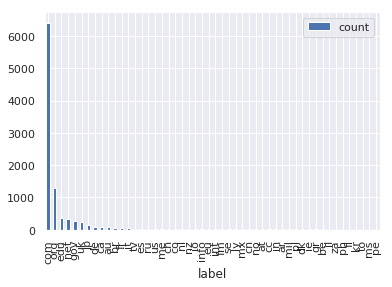

In [323]:
plt.figure(figsize=(9, 6))
df = pd.DataFrame.from_dict({'label': top_labels, 'count': top_counts})
df = df.set_index('label')
_ = df.plot(kind='bar')

We also want these labels to have consecutive integer IDs:

In [324]:
top_labels

('com',
 'org',
 'edu',
 'net',
 'gov',
 'uk',
 'jp',
 'de',
 'ca',
 'au',
 'br',
 'fr',
 'it',
 'tv',
 'es',
 'ru',
 'us',
 'me',
 'ch',
 'co',
 'nl',
 'nz',
 'io',
 'info',
 'eu',
 'int',
 'fm',
 'se',
 'ly',
 'mx',
 'cn',
 'no',
 'at',
 'cc',
 'in',
 'ar',
 'mil',
 'pl',
 'dk',
 'ie',
 'gr',
 'be',
 'il',
 'za',
 'ph',
 'fi',
 'kr',
 'to',
 'ms',
 'pe')

In [325]:
label_to_id = {}
for index, label in enumerate(top_labels):
    label_to_id[label] = index
label_to_id

{'com': 0,
 'org': 1,
 'edu': 2,
 'net': 3,
 'gov': 4,
 'uk': 5,
 'jp': 6,
 'de': 7,
 'ca': 8,
 'au': 9,
 'br': 10,
 'fr': 11,
 'it': 12,
 'tv': 13,
 'es': 14,
 'ru': 15,
 'us': 16,
 'me': 17,
 'ch': 18,
 'co': 19,
 'nl': 20,
 'nz': 21,
 'io': 22,
 'info': 23,
 'eu': 24,
 'int': 25,
 'fm': 26,
 'se': 27,
 'ly': 28,
 'mx': 29,
 'cn': 30,
 'no': 31,
 'at': 32,
 'cc': 33,
 'in': 34,
 'ar': 35,
 'mil': 36,
 'pl': 37,
 'dk': 38,
 'ie': 39,
 'gr': 40,
 'be': 41,
 'il': 42,
 'za': 43,
 'ph': 44,
 'fi': 45,
 'kr': 46,
 'to': 47,
 'ms': 48,
 'pe': 49}

In [326]:
top_labels_with_dot = list(map(lambda x: '.' + x, top_labels))

## Save the Dataset to File

In [327]:
N = G.number_of_nodes()
rows = [matid for matid in range(N) if node_to_label[matid_to_node[matid]] in label_to_id]

In [328]:
cols = [label_to_id[node_to_label[matid_to_node[matid]] ] for matid in range(N) \
        if node_to_label[matid_to_node[matid]] in label_to_id]

In [329]:
len(rows), len(cols)

(9886, 9886)

In [330]:
label_mat = csr_matrix( ( ([1.0] * len(rows)), (rows, cols) ), shape=(N, K_label) )
label_mat

<10000x50 sparse matrix of type '<class 'numpy.float64'>'
	with 9886 stored elements in Compressed Sparse Row format>

In [331]:
data_fname = 'example_graphs/www-10k.mat'

In [332]:
savemat(data_fname, {'network': A, 'group': label_mat})

# FastRP

In [312]:
import optuna
prefix = 'result/www-10k'

In [284]:
%%time
order_range = 2
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    weights = [trial.suggest_loguniform('weight' + str(order), 1.0, 64.0) for order in range(order_range)]
    alpha = trial.suggest_uniform('alpha', -1.0, 0.0)
    conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0] + weights,
        'normalization': True,
        'dim': 512,
        'alpha': alpha,
        'C': 1.0
    }
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = fastrp_wrapper(A, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = scoring(
        [
            "--emb", emb_filename,
            "--network", data_fname,
            "--num-shuffles", "5",
            "--debug",
            "--C", str(conf['C']),
            "--training-percents", "1",
        ]
    )
    # there should only be one entry here
    return -f1_scores[0]['macro']

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.3337256535496693,5.029748950429264,alpha=-0.4164264573080855,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9207081436519979, 'macro': 0.11524299447593016}
-------------------


[I 2019-05-21 16:07:54,894] Finished trial#0 resulted in value: -0.11524299447593016. Current best value is -0.11524299447593016 with parameters: {'weight0': 2.3337256535496693, 'weight1': 5.029748950429264, 'alpha': -0.4164264573080855}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.6765972088331913,1.1125677662369542,alpha=-0.6765518696637268,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9182599898836621, 'macro': 0.10092346845346763}
-------------------


[I 2019-05-21 16:07:57,763] Finished trial#1 resulted in value: -0.10092346845346763. Current best value is -0.11524299447593016 with parameters: {'weight0': 2.3337256535496693, 'weight1': 5.029748950429264, 'alpha': -0.4164264573080855}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,14.039019475149264,10.125615641266847,alpha=-0.9080915421591357,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.925078401618614, 'macro': 0.14481066344741067}
-------------------


[I 2019-05-21 16:08:00,852] Finished trial#2 resulted in value: -0.14481066344741067. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,54.05708684837646,5.3838920961489105,alpha=-0.6058869623542692,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9114618108244816, 'macro': 0.11992989812477459}
-------------------


[I 2019-05-21 16:08:03,893] Finished trial#3 resulted in value: -0.11992989812477459. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.073560799228505,13.832088990469353,alpha=-0.5717857791205863,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9266363176530096, 'macro': 0.1163810400594804}
-------------------


[I 2019-05-21 16:08:07,592] Finished trial#4 resulted in value: -0.1163810400594804. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,41.08755554239334,18.74239148060552,alpha=-0.18451537380388217,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9145574102175014, 'macro': 0.11659174622562166}
-------------------


[I 2019-05-21 16:08:12,355] Finished trial#5 resulted in value: -0.11659174622562166. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,42.83171737504722,42.123621460145436,alpha=-0.6456138172974734,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9194132524026303, 'macro': 0.10473638534530486}
-------------------


[I 2019-05-21 16:08:16,784] Finished trial#6 resulted in value: -0.10473638534530486. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.739127126858889,9.126770797397127,alpha=-0.5027226167601563,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9247951441578148, 'macro': 0.13421278381233234}
-------------------


[I 2019-05-21 16:08:20,706] Finished trial#7 resulted in value: -0.13421278381233234. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.17197625261654,1.711461559172285,alpha=-0.37142343402956013,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9206069802731411, 'macro': 0.13948285117896572}
-------------------


[I 2019-05-21 16:08:24,060] Finished trial#8 resulted in value: -0.13948285117896572. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,10.154222401991948,3.496361622124151,alpha=-0.18995338512709325,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9057561962569551, 'macro': 0.11972420356113042}
-------------------


[I 2019-05-21 16:08:27,513] Finished trial#9 resulted in value: -0.11972420356113042. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,14.651759077189865,28.837004291951885,alpha=-0.9962180549535388,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9205867475973697, 'macro': 0.13930390568597872}
-------------------


[I 2019-05-21 16:08:30,706] Finished trial#10 resulted in value: -0.13930390568597872. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,19.98605363829098,2.0830965612069257,alpha=-0.8381294941599866,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9252604957005565, 'macro': 0.1186314087609948}
-------------------


[I 2019-05-21 16:08:34,251] Finished trial#11 resulted in value: -0.1186314087609948. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0984197111048342,53.219315390998794,alpha=-0.8523653666675178,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9213353566009104, 'macro': 0.12353537597081372}
-------------------


[I 2019-05-21 16:08:38,639] Finished trial#12 resulted in value: -0.12353537597081372. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,25.427542405289724,63.648638391253485,alpha=-0.8333326178056523,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9129994941831058, 'macro': 0.11248762771226004}
-------------------


[I 2019-05-21 16:08:42,592] Finished trial#13 resulted in value: -0.11248762771226004. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,6.222751216095586,10.887934803968001,alpha=-0.9826461602542339,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9244107233181588, 'macro': 0.11749623231617028}
-------------------


[I 2019-05-21 16:08:46,736] Finished trial#14 resulted in value: -0.11749623231617028. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.370525114894763,21.528830376842336,alpha=-0.02209971913628539,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.921740010116338, 'macro': 0.11884324844767605}
-------------------


[I 2019-05-21 16:08:50,129] Finished trial#15 resulted in value: -0.11884324844767605. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.5554971344851165,2.376092250574848,alpha=-0.9970093730459872,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9174506828528074, 'macro': 0.1158637381471755}
-------------------


[I 2019-05-21 16:08:53,354] Finished trial#16 resulted in value: -0.1158637381471755. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.218161737728533,1.5833507908577897,alpha=-0.3342376069893185,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9279514415781487, 'macro': 0.12745786862759506}
-------------------


[I 2019-05-21 16:08:56,563] Finished trial#17 resulted in value: -0.12745786862759506. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.050443897975797,5.402023027296797,alpha=-0.20375841297367628,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9301972685887708, 'macro': 0.136210278845346}
-------------------


[I 2019-05-21 16:08:59,973] Finished trial#18 resulted in value: -0.136210278845346. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,16.558103595042077,3.094121303731902,alpha=-0.7489814522058769,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9168437025796662, 'macro': 0.11181312589138419}
-------------------


[I 2019-05-21 16:09:03,233] Finished trial#19 resulted in value: -0.11181312589138419. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.026200121369207,1.0234917796517138,alpha=-0.38249245782213476,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9142336874051594, 'macro': 0.11861475440137134}
-------------------


[I 2019-05-21 16:09:06,521] Finished trial#20 resulted in value: -0.11861475440137134. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,29.39579334087227,7.052623604462207,alpha=-0.30941390673670616,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9076378351036924, 'macro': 0.11885167448945902}
-------------------


[I 2019-05-21 16:09:11,320] Finished trial#21 resulted in value: -0.11885167448945902. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.84983619960489,1.4265442826385781,alpha=-0.4656804379781689,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9377440566514921, 'macro': 0.1419753026817447}
-------------------


[I 2019-05-21 16:09:16,143] Finished trial#22 resulted in value: -0.1419753026817447. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,12.98469666284243,3.5024297687709676,alpha=-0.5090400050993972,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9243702579666161, 'macro': 0.1347593584699659}
-------------------


[I 2019-05-21 16:09:20,258] Finished trial#23 resulted in value: -0.1347593584699659. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.90246476432905,1.0716076967777304,alpha=-0.8927370154739038,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9306626201315125, 'macro': 0.13360640131613963}
-------------------


[I 2019-05-21 16:09:23,799] Finished trial#24 resulted in value: -0.13360640131613963. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,11.171677399574405,14.367717867192644,alpha=-0.7570852026933089,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9219423368740516, 'macro': 0.1250488604711793}
-------------------


[I 2019-05-21 16:09:27,397] Finished trial#25 resulted in value: -0.1250488604711793. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.799142991837045,1.4286284722125204,alpha=-0.7324811233183643,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9148406676783004, 'macro': 0.11649371630044718}
-------------------


[I 2019-05-21 16:09:31,166] Finished trial#26 resulted in value: -0.11649371630044718. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,21.345441812912576,7.280365353231555,alpha=-0.9060474259973742,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9266160849772384, 'macro': 0.13548194725597945}
-------------------


[I 2019-05-21 16:09:34,784] Finished trial#27 resulted in value: -0.13548194725597945. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.6856264932061689,4.547729075603478,alpha=-0.43864015245044835,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9330703085483055, 'macro': 0.14168125989988928}
-------------------


[I 2019-05-21 16:09:40,078] Finished trial#28 resulted in value: -0.14168125989988928. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.3799715226543072,2.405985342015716,alpha=-0.11717683160325026,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9111987860394537, 'macro': 0.11813484881700316}
-------------------


[I 2019-05-21 16:09:44,435] Finished trial#29 resulted in value: -0.11813484881700316. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.980310124291085,32.32942665308288,alpha=-0.2730057315966871,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.925725847243298, 'macro': 0.1283419363804798}
-------------------


[I 2019-05-21 16:09:48,617] Finished trial#30 resulted in value: -0.1283419363804798. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,34.599609561584565,4.471092941440952,alpha=-0.575079558664483,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9061810824481537, 'macro': 0.11643521723976813}
-------------------


[I 2019-05-21 16:09:52,241] Finished trial#31 resulted in value: -0.11643521723976813. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.44660246520135,11.650759331100522,alpha=-0.44241675777643885,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.928295397066262, 'macro': 0.14312697274265776}
-------------------


[I 2019-05-21 16:09:55,900] Finished trial#32 resulted in value: -0.14312697274265776. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,62.29724237450159,13.020273301020467,alpha=-0.6570431839002576,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9220435002529083, 'macro': 0.12392931707259576}
-------------------


[I 2019-05-21 16:09:59,672] Finished trial#33 resulted in value: -0.12392931707259576. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,16.049914113632834,18.683759941975232,alpha=-0.09724396973400906,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9151036924633283, 'macro': 0.13152652777508791}
-------------------


[I 2019-05-21 16:10:03,264] Finished trial#34 resulted in value: -0.13152652777508791. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.795965350395997,26.24981758170478,alpha=-0.5545280881648313,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9261507334344966, 'macro': 0.127906992381745}
-------------------


[I 2019-05-21 16:10:07,596] Finished trial#35 resulted in value: -0.127906992381745. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,42.992880478168246,39.59720768177167,alpha=-0.6124270562760225,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9288619119878604, 'macro': 0.1421527495868143}
-------------------


[I 2019-05-21 16:10:11,786] Finished trial#36 resulted in value: -0.1421527495868143. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,12.352130843890526,9.427362480070933,alpha=-0.7032141117723936,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.920101163378857, 'macro': 0.1176988904830552}
-------------------


[I 2019-05-21 16:10:15,841] Finished trial#37 resulted in value: -0.1176988904830552. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,19.963677650465947,6.230443412908264,alpha=-0.9403853700967271,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9155892766818413, 'macro': 0.11712335805631206}
-------------------


[I 2019-05-21 16:10:19,704] Finished trial#38 resulted in value: -0.11712335805631206. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.221145524799891,16.22197897062468,alpha=-0.4073258690272243,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9194941831057157, 'macro': 0.12349205133985866}
-------------------


[I 2019-05-21 16:10:23,263] Finished trial#39 resulted in value: -0.12349205133985866. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,28.758787088320744,9.461914600845992,alpha=-0.8022698027408701,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9260091047040971, 'macro': 0.12686971810739728}
-------------------


[I 2019-05-21 16:10:26,492] Finished trial#40 resulted in value: -0.12686971810739728. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.052281557832535,51.71718626088307,alpha=-0.2579020189982541,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9071724835609508, 'macro': 0.11060916088320587}
-------------------


[I 2019-05-21 16:10:30,324] Finished trial#41 resulted in value: -0.11060916088320587. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,10.318289744187368,23.182841091705413,alpha=-0.6219092134286583,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9190288315629742, 'macro': 0.11342883617917124}
-------------------


[I 2019-05-21 16:10:33,410] Finished trial#42 resulted in value: -0.11342883617917124. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,13.639670657502897,34.43434030213963,alpha=-0.5101037478257879,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.919676277187658, 'macro': 0.12088132895871473}
-------------------


[I 2019-05-21 16:10:36,576] Finished trial#43 resulted in value: -0.12088132895871473. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,51.93487439844495,11.468021090028095,alpha=-0.6877280339411239,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.924693980778958, 'macro': 0.11227494117543683}
-------------------


[I 2019-05-21 16:10:40,496] Finished trial#44 resulted in value: -0.11227494117543683. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,23.82350438142094,7.9903943988670685,alpha=-0.7995626217996679,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9180576631259484, 'macro': 0.10878157464925726}
-------------------


[I 2019-05-21 16:10:44,395] Finished trial#45 resulted in value: -0.10878157464925726. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.3886493947585326,18.860686696635383,alpha=-0.07383184006488014,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.919008598887203, 'macro': 0.12072702320457258}
-------------------


[I 2019-05-21 16:10:49,217] Finished trial#46 resulted in value: -0.12072702320457258. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.8609912796517385,3.3352161562310005,alpha=-0.9357038975802882,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9311077389984825, 'macro': 0.13112120345097097}
-------------------


[I 2019-05-21 16:10:53,046] Finished trial#47 resulted in value: -0.13112120345097097. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.5375676525934323,5.649672602414282,alpha=-0.5544819921822159,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.913889731917046, 'macro': 0.12475727415069864}
-------------------


[I 2019-05-21 16:10:56,629] Finished trial#48 resulted in value: -0.12475727415069864. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.4683847185110936,48.40449401979249,alpha=-0.3486719861482672,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9212746585735964, 'macro': 0.11033075909812107}
-------------------


[I 2019-05-21 16:10:59,833] Finished trial#49 resulted in value: -0.11033075909812107. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,17.586100754626703,4.083882155140166,alpha=-0.22881328737905343,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9166818411734953, 'macro': 0.11919760505020396}
-------------------


[I 2019-05-21 16:11:02,804] Finished trial#50 resulted in value: -0.11919760505020396. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,35.936256145705634,11.996339942804747,alpha=-0.14033870326044823,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9244511886697016, 'macro': 0.1105330635668896}
-------------------


[I 2019-05-21 16:11:05,970] Finished trial#51 resulted in value: -0.1105330635668896. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,49.22488594176739,15.926185016388823,alpha=-0.47249707388447115,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9269195751138088, 'macro': 0.12081047700354483}
-------------------


[I 2019-05-21 16:11:10,197] Finished trial#52 resulted in value: -0.12081047700354483. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.9461053454652186,2.8648047498060256,alpha=-0.8552018023788537,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9143550834597874, 'macro': 0.11417275325202954}
-------------------


[I 2019-05-21 16:11:14,293] Finished trial#53 resulted in value: -0.11417275325202954. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.815020818479178,62.87569281155013,alpha=-0.9775396951279691,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9237632776934749, 'macro': 0.11328361627721213}
-------------------


[I 2019-05-21 16:11:18,179] Finished trial#54 resulted in value: -0.11328361627721213. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.9438936512989353,1.8259738483241397,alpha=-0.29188366832113055,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9187253414264036, 'macro': 0.12583838838971526}
-------------------


[I 2019-05-21 16:11:21,960] Finished trial#55 resulted in value: -0.12583838838971526. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.729154800625467,6.369158260502903,alpha=-0.7915144244758064,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9253211937278705, 'macro': 0.12639720606074248}
-------------------


[I 2019-05-21 16:11:25,743] Finished trial#56 resulted in value: -0.12639720606074248. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.349515066616272,8.31335885102435,alpha=-0.8769251993353024,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9220435002529085, 'macro': 0.1282433230497937}
-------------------


[I 2019-05-21 16:11:29,105] Finished trial#57 resulted in value: -0.1282433230497937. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,10.528571752795983,10.546321688197246,alpha=-0.4019658169841595,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9088922610015174, 'macro': 0.12178876627450093}
-------------------


[I 2019-05-21 16:11:32,178] Finished trial#58 resulted in value: -0.12178876627450093. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,14.672840935449832,26.969716502827506,alpha=-0.7153299709515986,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9294081942336874, 'macro': 0.13954633402791955}
-------------------


[I 2019-05-21 16:11:35,777] Finished trial#59 resulted in value: -0.13954633402791955. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.9748026868808,2.5391711319187205,alpha=-0.6409528594248667,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9191906929691452, 'macro': 0.1250325302680287}
-------------------


[I 2019-05-21 16:11:39,221] Finished trial#60 resulted in value: -0.1250325302680287. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,18.758457661326812,22.62193420133428,alpha=-0.1680973620862114,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9115629742033384, 'macro': 0.11537938393685124}
-------------------


[I 2019-05-21 16:11:43,211] Finished trial#61 resulted in value: -0.11537938393685124. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,22.757211808151027,5.030631828775304,alpha=-0.7629773529492184,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9309054122407687, 'macro': 0.13271820118745492}
-------------------


[I 2019-05-21 16:11:48,069] Finished trial#62 resulted in value: -0.13271820118745492. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,28.57038924037927,4.105468929714759,alpha=-0.047557090957159265,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9237430450177035, 'macro': 0.12861770696909694}
-------------------


[I 2019-05-21 16:11:52,540] Finished trial#63 resulted in value: -0.12861770696909694. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.046373478963005,14.307409920112633,alpha=-0.5302413229784697,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9151441578148709, 'macro': 0.1162564693974392}
-------------------


[I 2019-05-21 16:11:57,053] Finished trial#64 resulted in value: -0.1162564693974392. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,42.773937151729,45.664932320724475,alpha=-0.6690241860460432,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9263125948406676, 'macro': 0.1376370485397839}
-------------------


[I 2019-05-21 16:12:00,414] Finished trial#65 resulted in value: -0.1376370485397839. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,60.91003380184786,39.18049526759203,alpha=-0.9617120401320631,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9204248861911989, 'macro': 0.12402499948076531}
-------------------


[I 2019-05-21 16:12:03,443] Finished trial#66 resulted in value: -0.12402499948076531. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,35.94380470383988,35.682298719074076,alpha=-0.4487334159657561,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9182599898836621, 'macro': 0.10399084840357549}
-------------------


[I 2019-05-21 16:12:06,708] Finished trial#67 resulted in value: -0.10399084840357549. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,12.322033368533795,60.543855237904125,alpha=-0.5924296045378166,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9170055639858372, 'macro': 0.13015803302097412}
-------------------


[I 2019-05-21 16:12:10,351] Finished trial#68 resulted in value: -0.13015803302097412. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,31.666698448615684,20.33708161019039,alpha=-0.615172888067517,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9296712190187153, 'macro': 0.13980037188444033}
-------------------


[I 2019-05-21 16:12:13,478] Finished trial#69 resulted in value: -0.13980037188444033. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,26.03565589945769,41.739625992553634,alpha=-0.8224164007094067,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9231967627718765, 'macro': 0.13288773204474577}
-------------------


[I 2019-05-21 16:12:18,383] Finished trial#70 resulted in value: -0.13288773204474577. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,39.87050938146382,27.540771884061627,alpha=-0.8980470478050516,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.930156803237228, 'macro': 0.1432550209043185}
-------------------


[I 2019-05-21 16:12:23,216] Finished trial#71 resulted in value: -0.1432550209043185. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,15.066465069536294,16.340436976650526,alpha=-0.36797088555044144,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9171876580677795, 'macro': 0.12106944759412297}
-------------------


[I 2019-05-21 16:12:27,445] Finished trial#72 resulted in value: -0.12106944759412297. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.128523449443725,13.13198667594805,alpha=-0.3232682837701233,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9270612038442085, 'macro': 0.123249231213059}
-------------------


[I 2019-05-21 16:12:31,141] Finished trial#73 resulted in value: -0.123249231213059. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.263380590015482,29.207743709523044,alpha=-0.0034861462261019383,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9285584218512899, 'macro': 0.12493918492566433}
-------------------


[I 2019-05-21 16:12:34,218] Finished trial#74 resulted in value: -0.12493918492566433. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.669107180817766,9.959983383859212,alpha=-0.4801376811386229,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.916621143146181, 'macro': 0.11154613487291629}
-------------------


[I 2019-05-21 16:12:37,153] Finished trial#75 resulted in value: -0.11154613487291629. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,47.75185846580251,31.252609622794996,alpha=-0.438342926191026,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9193727870510875, 'macro': 0.13765803798189624}
-------------------


[I 2019-05-21 16:12:40,191] Finished trial#76 resulted in value: -0.13765803798189624. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,20.356403517204566,24.671054553574326,alpha=-0.8988893461772821,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9264137582195244, 'macro': 0.11543251251824031}
-------------------


[I 2019-05-21 16:12:43,580] Finished trial#77 resulted in value: -0.11543251251824031. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.38212084576058,7.587945040368134,alpha=-0.5298424422271755,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9194334850784017, 'macro': 0.1297689040678333}
-------------------


[I 2019-05-21 16:12:47,260] Finished trial#78 resulted in value: -0.1297689040678333. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,58.159621044536586,18.066916675694774,alpha=-0.7347314280954979,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9253211937278707, 'macro': 0.1364649767064347}
-------------------


[I 2019-05-21 16:12:52,486] Finished trial#79 resulted in value: -0.1364649767064347. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,11.54798543129898,8.662441750217544,alpha=-0.2360903705191295,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9218007081436521, 'macro': 0.12019307068154994}
-------------------


[I 2019-05-21 16:12:57,190] Finished trial#80 resulted in value: -0.12019307068154994. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,6.543302045014862,6.315413118116303,alpha=-0.9193158137352527,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9249772382397572, 'macro': 0.1420181904426115}
-------------------


[I 2019-05-21 16:13:01,396] Finished trial#81 resulted in value: -0.1420181904426115. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0132479547291786,11.945002098109168,alpha=-0.5762018450546151,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9281537683358625, 'macro': 0.13284784244089134}
-------------------


[I 2019-05-21 16:13:04,842] Finished trial#82 resulted in value: -0.13284784244089134. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,17.717097959449767,15.215398111374347,alpha=-0.7785205429640571,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9307637835103693, 'macro': 0.12802038887094228}
-------------------


[I 2019-05-21 16:13:08,061] Finished trial#83 resulted in value: -0.12802038887094228. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.409117912758438,6.9354910764716795,alpha=-0.9960986580716749,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9258067779463834, 'macro': 0.11423567970086348}
-------------------


[I 2019-05-21 16:13:11,525] Finished trial#84 resulted in value: -0.11423567970086348. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,38.167684919448796,57.46180446336924,alpha=-0.8698550137221959,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9203641881638849, 'macro': 0.1341907295410755}
-------------------


[I 2019-05-21 16:13:14,982] Finished trial#85 resulted in value: -0.1341907295410755. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,13.258031863608824,5.642120781824803,alpha=-0.38203284495097733,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9136874051593324, 'macro': 0.11362384443639377}
-------------------


[I 2019-05-21 16:13:17,946] Finished trial#86 resulted in value: -0.11362384443639377. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,25.44290370806909,20.616926089642966,alpha=-0.29905784358213505,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9196560445118868, 'macro': 0.11574583350534211}
-------------------


[I 2019-05-21 16:13:21,885] Finished trial#87 resulted in value: -0.11574583350534211. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.482086274361188,10.089526884224158,alpha=-0.6899609722339826,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9294891249367729, 'macro': 0.13684336974501465}
-------------------


[I 2019-05-21 16:13:26,997] Finished trial#88 resulted in value: -0.13684336974501465. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,31.592889403408932,13.397297608282528,alpha=-0.6407004346500864,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9126757713707638, 'macro': 0.1088481617892759}
-------------------


[I 2019-05-21 16:13:31,560] Finished trial#89 resulted in value: -0.1088481617892759. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,16.47303119444603,25.26231670979635,alpha=-0.830134178583883,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9262923621648962, 'macro': 0.12526997753070668}
-------------------


[I 2019-05-21 16:13:35,763] Finished trial#90 resulted in value: -0.12526997753070668. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.48462292397312,17.218805422996493,alpha=-0.41695821004853434,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9215579160343956, 'macro': 0.12028116045677328}
-------------------


[I 2019-05-21 16:13:39,271] Finished trial#91 resulted in value: -0.12028116045677328. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,21.86610863361285,11.351134371176768,alpha=-0.5323473604994639,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9091350531107739, 'macro': 0.10872170434959842}
-------------------


[I 2019-05-21 16:13:42,566] Finished trial#92 resulted in value: -0.10872170434959842. Current best value is -0.14481066344741067 with parameters: {'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.044682156021523,35.80558912719051,alpha=-0.2672604876519299,C=1.0.mat
Train percent: 0.01


KeyboardInterrupt: 

In [285]:
study.best_trial

FrozenTrial(number=2, state=<TrialState.COMPLETE: 1>, value=-0.14481066344741067, datetime_start=datetime.datetime(2019, 5, 21, 16, 7, 57, 765525), datetime_complete=datetime.datetime(2019, 5, 21, 16, 8, 0, 852312), params={'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}, user_attrs={}, system_attrs={'_number': 2}, intermediate_values={}, params_in_internal_repr={'weight0': 14.039019475149264, 'weight1': 10.125615641266847, 'alpha': -0.9080915421591357}, trial_id=2)

In [333]:
%%time
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, 14, 11],
        'normalization': True,
        'dim': 512,
        'alpha': -0.91,
        'C': 1.0
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = fastrp_wrapper(A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores, result = scoring(
    [
        "--emb", emb_filename,
        "--network", data_fname,
        "--num-shuffles", "5",
        "--debug",
        "--result",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
)
f1_scores

result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,14,11,alpha=-0.91,C=1.0.mat
File result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,14,11,alpha=-0.91,C=1.0.mat already exists, skipped.
Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9259910093992645, 'macro': 0.265694656354719}
-------------------
Train percent: 0.02
Average score: {'micro': 0.9484363711425328, 'macro': 0.353421525849046}
-------------------
Train percent: 0.03
Average score: {'micro': 0.9669447340980188, 'macro': 0.44585447003149686}
-------------------
Train percent: 0.04
Average score: {'micro': 0.9717837951743757, 'macro': 0.4977702267426608}
-------------------
Train p

In [ ]:
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, 11.66, 57.20],
        'normalization': True,
        'dim': 512,
        'alpha': -0.646,
        'C': 1.0
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = fastrp_wrapper(A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores, result = scoring(
    [
        "--emb", emb_filename,
        "--network", data_fname,
        "--num-shuffles", "5",
        "--debug",
        "--result",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
)
f1_scores

In [ ]:
# conf = {
#         'projection_method': 'sparse',
#         'input_matrix': 'trans',
#         'weights': [1.0, 1.0, study.best_params['weight0'], study.best_params['weight1'] ],
#         'normalization': True,
#         'dim': 512,
#         'alpha': study.best_params['alpha'],
#         'C': 1.0
#     }
# emb_filename = get_emb_filename(prefix, conf)
# print (emb_filename)
# # first check if this file already exists
# path = Path(emb_filename)
# if not path.is_file():
#     U = fastrp_wrapper(A, conf)
#     savemat(emb_filename, {'emb': U})
# else:
#     print ('File %s already exists, skipped.' % emb_filename)
# f1_scores, result = scoring(
#     [
#         "--emb", emb_filename,
#         "--network", data_fname,
#         "--num-shuffles", "5",
#         "--debug",
#         "--result",
#         "--C", str(conf['C']),
#         "--training-percents",
#     ] + [str(p) for p in range(1, 10)],
# )
# f1_scores

# Run DeepWalk

Run the following command in shell:

In [ ]:
nohup time deepwalk --format mat --input /mnt/store1/hcchen/www-network/10k-classification.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 28 --output /home/hcchen/fast-random-projection/result/www-10k-dw-emb.mat &

Load DeepWalk embeddings:

In [68]:
dw_emb_fname = '/home/hcchen/fast-random-projection/result/www-10k-dw-emb.mat'

In [69]:
model = KeyedVectors.load_word2vec_format(dw_emb_fname, binary=False)

In [70]:
N = len(model.vocab)
%time dw_emb = np.asarray([model[str(node)] for node in range(N)])

CPU times: user 27.1 ms, sys: 458 µs, total: 27.5 ms
Wall time: 27.1 ms


In [71]:
dw_emb.shape

(10000, 128)

In [334]:
%%time
dw_f1_scores = scoring(
    [
        "--network", data_fname,
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
    dw_emb
)
dw_f1_scores

Load embeddings from memory...
Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.931875766244381, 'macro': 0.2742805917487515}
-------------------
Train percent: 0.02
Average score: {'micro': 0.9457941996078028, 'macro': 0.3590375765144605}
-------------------
Train percent: 0.03
Average score: {'micro': 0.9560375391032325, 'macro': 0.44042351295566007}
-------------------
Train percent: 0.04
Average score: {'micro': 0.9645348224633864, 'macro': 0.5046969780125964}
-------------------
Train percent: 0.05
Average score: {'micro': 0.9727214650766609, 'macro': 0.552935364532743}
-------------------
Train percent: 0.06
Average score: {'micro': 0.9777036479070269, 'macro': 0.6045487945774374}
-------------------
Train percent: 0.07
Average score: {'m

# Run RandNE

Run the following command in shell:

In [335]:
data_fname

'example_graphs/www-10k.mat'

In [ ]:
cd ~/RandNE-Python/ && 
time python3 src/randne.py --input /home/hcchen/fast-random-projection/example_graphs/www-10k.mat \
--output /home/hcchen/fast-random-projection/result/www-10k-randne-emb.mat \
--use-trans-matrix -q 3 -d 512 --weights 1 100 1000

In [337]:
f1_scores, result = scoring(
    [
        "--emb", "/home/hcchen/fast-random-projection/result/www-10k-randne-emb.mat",
        "--network", data_fname,
        "--num-shuffles", "5",
        "--debug",
        "--result",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
)
f1_scores

Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.8891704127503065, 'macro': 0.15675233825909993}
-------------------
Train percent: 0.02
Average score: {'micro': 0.9239343585509341, 'macro': 0.1902940128879356}
-------------------
Train percent: 0.03
Average score: {'micro': 0.9342440041710114, 'macro': 0.225875165965545}
-------------------
Train percent: 0.04
Average score: {'micro': 0.948646085765462, 'macro': 0.2958123201950469}
-------------------
Train percent: 0.05
Average score: {'micro': 0.956324531516184, 'macro': 0.33664860201421887}
-------------------
Train percent: 0.06
Average score: {'micro': 0.9624878941138493, 'macro': 0.36984244598270605}
-------------------
Train percent: 0.07
Average score: {'micro': 0.966760931041984, 'mac

[defaultdict(float,
             {'micro': 0.8891704127503065,
              'macro': 0.15675233825909993,
              'training': 0.01}),
 defaultdict(float,
             {'micro': 0.9239343585509341,
              'macro': 0.1902940128879356,
              'training': 0.02}),
 defaultdict(float,
             {'micro': 0.9342440041710114,
              'macro': 0.225875165965545,
              'training': 0.03}),
 defaultdict(float,
             {'micro': 0.948646085765462,
              'macro': 0.2958123201950469,
              'training': 0.04}),
 defaultdict(float,
             {'micro': 0.956324531516184,
              'macro': 0.33664860201421887,
              'training': 0.05}),
 defaultdict(float,
             {'micro': 0.9624878941138493,
              'macro': 0.36984244598270605,
              'training': 0.06}),
 defaultdict(float,
             {'micro': 0.966760931041984,
              'macro': 0.3976186371448614,
              'training': 0.07}),
 defaultdict(float,
 

# Run node2vec

In [ ]:
cd /home/hcchen/deepwalk-sgns/deepwalk && nohup time python __main__.py --format mat \
--input /home/hcchen/fast-random-projection/example_graphs/www-10k.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 40 --output /home/hcchen/deepwalk-sgns/example_graphs/www-10k.node2vec.emb &

In [338]:
%%time
node2vec_f1_scores = scoring(
    [
        "--emb", "/home/hcchen/deepwalk-sgns/example_graphs/www-10k.node2vec.emb",
        "--network", data_fname,
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
)
node2vec_f1_scores

Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.9307928075194114, 'macro': 0.2553652306175958}
-------------------
Train percent: 0.02
Average score: {'micro': 0.9524821963050882, 'macro': 0.3761343667806067}
-------------------
Train percent: 0.03
Average score: {'micro': 0.9636496350364963, 'macro': 0.4496494312584415}
-------------------
Train percent: 0.04
Average score: {'micro': 0.9682225266041513, 'macro': 0.49955510412430987}
-------------------
Train percent: 0.05
Average score: {'micro': 0.9727427597955707, 'macro': 0.5398461986826322}
-------------------
Train percent: 0.06
Average score: {'micro': 0.9764338749596471, 'macro': 0.5789415261657154}
-------------------
Train percent: 0.07
Average score: {'micro': 0.9777463563193386, 'm

# Run LINE

Save the graph as edgelist:

In [346]:
A

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 7809220 stored elements in Compressed Sparse Row format>

In [368]:
G = nx.from_scipy_sparse_matrix(A)
G.number_of_nodes(), G.number_of_edges()

(10000, 3904610)

In [369]:
nx.write_edgelist(G.to_directed(), open('example_graphs/www-10k.edgelist', 'wb'), data=['weight'])

Compile the code:

In [ ]:
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result line.cpp -o line -lgsl -lm -lgslcblas
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result reconstruct.cpp -o reconstruct
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result normalize.cpp -o normalize
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result concatenate.cpp -o concatenate

First add the GSL library to path in shell:

In [ ]:
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/hcchen/gsl/lib

Run LINE:

In [ ]:
cd ~/LINE/linux && nohup time ./line -train /home/hcchen/fast-random-projection/example_graphs/www-10k.edgelist \
-output /home/hcchen/fast-random-projection/result/www-10k.line.2.emb \
-binary 0 -size 200 -order 2 -negative 5 -samples 1000 -rho 0.025 -threads 20 &

In [ ]:
cd ~/LINE/linux && nohup time ./line -train /home/hcchen/fast-random-projection/example_graphs/www-10k.edgelist \
-output /home/hcchen/fast-random-projection/result/www-10k.line.1.emb \
-binary 0 -size 200 -order 1 -negative 5 -samples 1000 -rho 0.025 -threads 20 &

In [370]:
model = KeyedVectors.load_word2vec_format('/home/hcchen/fast-random-projection/result/www-10k.line.2.emb', binary=False)

In [375]:
N = len(model.vocab)
%time line_emb = np.asarray([model[str(matid)] for matid in range(N)])

CPU times: user 36.6 ms, sys: 14 µs, total: 36.6 ms
Wall time: 36 ms


In [376]:
line_emb.shape

(10000, 200)

In [377]:
%%time
line_f1_scores = scoring(
    [
        "--network", data_fname,
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
    line_emb
)
line_f1_scores

Load embeddings from memory...
Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 200
-------------------
Train percent: 0.01
Average score: {'micro': 0.6648344912137312, 'macro': 0.06659462910156154}
-------------------
Train percent: 0.02
Average score: {'micro': 0.682113737227784, 'macro': 0.09071906724470918}
-------------------
Train percent: 0.03
Average score: {'micro': 0.6883003128258602, 'macro': 0.09984615170854935}
-------------------
Train percent: 0.04
Average score: {'micro': 0.6935623221999789, 'macro': 0.1077886795744786}
-------------------
Train percent: 0.05
Average score: {'micro': 0.7040034071550256, 'macro': 0.12236954516394132}
-------------------
Train percent: 0.06
Average score: {'micro': 0.7052835467556224, 'macro': 0.12955873397265902}
-------------------
Train percent: 0.07
Average score

# Visualization

Another experiment is to see how well can both methods separate sites with different top-level domains in the embedding space. Let us still consider the same set of sites as in the classification experiment:

In [17]:
emb_200k_dw_classification = loadmat('/mnt/store1/hcchen/ws/large-network-embeddings/www-network/deepwalk-www-200k-classification.mat')['emb']

In [18]:
emb_200k_dw_classification.shape

(10000, 128)

In [ ]:
N = emb_200k_dw_classification.shape[0]

In [ ]:
tsne = TSNE(n_components=2, random_state=42)

For DeepWalk:

In [ ]:
%%time
deepwalk_tsne = tsne.fit_transform(emb_200k_dw_classification)

In [ ]:
deepwalk_tsne

In [ ]:
filtered_domains = set([0, 1, 2])

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightpink', 'orange', 'purple']
for label in range(K_label):
    if label in filtered_domains:
        continue
    candidates = [i for i in range(N) if cols[i] == label]
    plt.scatter(deepwalk_tsne[candidates, 0], deepwalk_tsne[candidates, 1],
                s=40, c=colors[label], label=top_labels_with_dot[label])
plt.legend()
# plt.legend(bbox_to_anchor=(1., 0., 1., 1.), loc=1,
#            ncol=1, mode="expand", borderaxespad=0., fontsize=16)
# plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.savefig('deepwalk-tsne.pdf')

For RandNE MATLAB Adj:

In [ ]:
%%time
randne_tsne = tsne.fit_transform(emb_randne_adj_200k_classification)

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightpink', 'orange', 'purple']
for label in range(K_label):
    if label in filtered_domains:
        continue
    candidates = [i for i in range(N) if cols[i] == label]
    plt.scatter(randne_tsne[candidates, 0], randne_tsne[candidates, 1],
                s=40, c=colors[label], label=top_labels_with_dot[label])
plt.legend()
# plt.legend(bbox_to_anchor=(1., 0., 1., 1.), loc=1,
#            ncol=1, mode="expand", borderaxespad=0., fontsize=16)
# plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.savefig('randne-tsne.pdf')

For RandNE Python Adj:

In [ ]:
%%time
randne_py_adj_tsne = tsne.fit_transform(emb_randne_py_adj_200k_classification)

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightpink', 'orange', 'purple']
for label in range(K_label):
    if label in filtered_domains:
        continue
    candidates = [i for i in range(N) if cols[i] == label]
    plt.scatter(randne_py_adj_tsne[candidates, 0], randne_py_adj_tsne[candidates, 1],
                s=40, c=colors[label], label=top_labels_with_dot[label])
plt.legend()
plt.savefig('randne-adj-tsne.pdf')

For RandNE Python Trans:

In [ ]:
%%time
randne_py_trans_tsne = tsne.fit_transform(emb_randne_py_trans_200k_classification)

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightpink', 'orange', 'purple']
for label in range(K_label):
    if label in filtered_domains:
        continue
    candidates = [i for i in range(N) if cols[i] == label]
    plt.scatter(randne_py_trans_tsne[candidates, 0], randne_py_trans_tsne[candidates, 1],
                s=40, c=colors[label], label=top_labels_with_dot[label])
plt.legend()
plt.savefig('randne-trans-tsne.pdf')

## Grid Search on RandNE Weights

Another thing to consider is grid searching for better RandNE weights: how does this affect the visualization result?